# Long Short-Term Memory Networks for Remaining Useful Life Estimation

Survival Analysis comprises of statistical approaches to analyze time to the underlying event of interest. The analysis may also be referred as reliability analysis. Here, we develop this package to understand the time series data of turbofan engines degradation simulations. The time series data contains hidden information that provides clues to the time to failure, also known as remaining useful life (RUL). Accurate estimation of RUL plays a critical role in health management of turbofan engines. This package preprocess and analyzes the data and develop a machine learning model to capture the hidden information such as interactions between multiple sensors measurements and degradation patterns. In this package, we propose Long Short-Term Memory (LSTM) approach for RUL estimation. LSTM models are based on neural network with cyclic connections that makes them powerful in modeling sequences and forecast the degradation patterns. 

### Table of Content

  * [Data Description](#Data-Description)
  * [Import Data](#Import-Data)
  * [Data Analysis](#Data-Analysis)
  * [Model Development](#Model-Development)
  * [Model Evaluation](#Model-Evaluation)

### Data Description

NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) data set (Turbofan Engine Degradation Simulation Data Set) is a widely used benchmark data. C-MAPSS data includes sensor data with different number of operating conditions and fault conditions [1].

|      Data Set        |  FD001 | FD002 | FD003 | FD004|
|----------------------|--------|-------|-------|------|
|  Train Trajectories  |  100   |  260  |  100  | 249  |
|   Test Trajectories  |  100   |  259  |  100  |  248 |
| Operating Conditions |    1   |   6   |   1   |   6  |
|    Fault Conditions  |    1   |   1   |   2   |   2  |

The data has 4 sub-data sets with different number of operating conditions and fault conditions and each sub-data set is further divided into training and test subsets, as shown in table above. We use dataset FD002 for our purpose. Each row in the data is a snapshot of data taken during a single operating time cycle, which includes 26 columns: 
 * 1st column represents engine ID, 
 * 2nd column represents the current operational cycle number, 
 * 3-5 columns are the three operational settings that have a substantial effect on engine performance, 
 * 6-26 columns represent the 21 sensor values. More information about the 21 sensors can be found in [2]. 

The engine is operating normally at the start of each time series, and develops a fault at some point in time which is unknown. In the training set, the fault grows in magnitude until a system failure. In the test set, data is provided up to some time prior to system failure. The goal is to estimate the number of remaining operational cycles before failure on the test data. In this package we use only FD002 dataset for demonstrating capabilities of LSTM to estimate remaining useful life.

[1] S. Zheng, K. Ristovski, A. Farahat and C. Gupta, "Long Short-Term Memory Network for Remaining Useful Life estimation," 2017 IEEE International Conference on Prognostics and Health Management (ICPHM), Dallas, TX, 2017, pp. 88-95.

[2] E. Ramasso and A. Saxena, “Performance benchmarking and analysis of prognostic methods for cmapss datasets.” International Journal of Prognostics and Health Management, vol. 5, no. 2, pp. 1–15, 2014.

### Import Data

'Turbofan Engine Degradation Simulation Data Set' can be downloaded from here: 
https://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/

In [1]:
# Import C-MAPSS Dataset FD002 train and test and records of RUL
from SAP.data_import import get_C_MAPSS_Data
data_training_FD2, data_testing_FD2, data_testing_RUL_FD2 = get_C_MAPSS_Data(path = 'Data', dataset = 'FD002')

Using TensorFlow backend.


[Info] Training Data Loading...
[Info] Testing Data Loading...
[Info] Loading records of RUL on this testing data...


### Data Analysis
Here we analyze information in the data. 

In [2]:
data_training_FD2.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


Training data contains engine_id as engine number and snapshot of different variables are given at cycles. The degradation of that engine grows with cycle. The training data contains the failure of engine at the last cycle that provides us the information of engine remaining useful life (RUL) at earliear cycles. Here we plot the histogram of RUL from all engines.

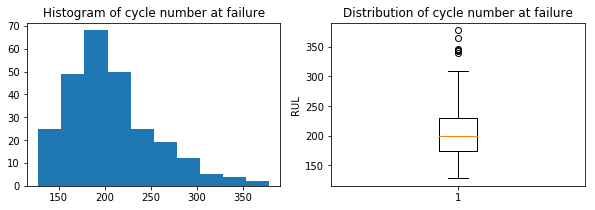

Average time-to-failure from the first cycle is: 206.34


In [3]:
# plot the RUL histogram of units
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
RULtraining = []
for unit in range(1,data_training_FD2['engine_id'].unique().shape[0]):
    RULtraining.append(data_training_FD2[data_training_FD2['engine_id'] == unit]['cycle'].max())
plt.hist(RULtraining)
plt.title('Histogram of cycle number at failure')

plt.subplot(1,2,2)
plt.boxplot(RULtraining)
plt.title('Distribution of cycle number at failure')
plt.ylabel('RUL')
plt.show()

print 'Average time-to-failure from the first cycle is: %.2f' %np.mean(RULtraining)

(minimum, maximum) values of RUL are observed as (128,378). The majority of engine fails near 200 cycles. 

### Model Development
This section consists of modeling data preparation, network architecture and model development with training data.

[Info] Generating a column 'time_of_event' using maximum cycle number...
[Info] Generating 'time_to_event' value for each engine at given cycle...
[Info] Centering the settings and sensors measurements...
[Info] Box plot of column variables:


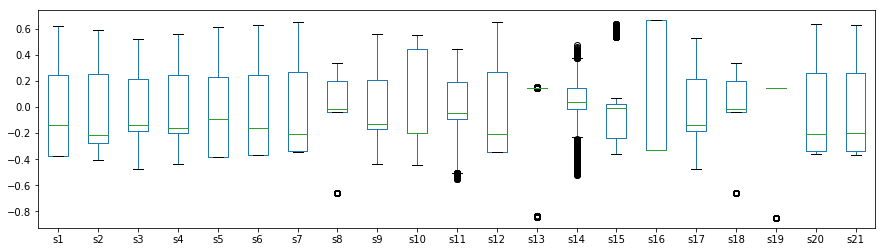

[Info] Normalizing the remaining useful life at given cycle...
[Info] Preparing the input and output label data for model training...
[Info] Plot of model training error:


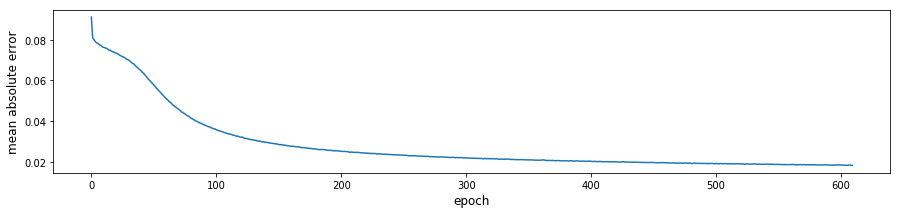

In [4]:
from SAP.model import LSTM_for_RUL
%matplotlib inline

# Build model
(data_training,
 Xtraining, 
 Ytraining, 
 model,
 settings_min_max_mean,
 sensors_min_max_mean,
 time_of_event_max,
 centering,
 normalization,
 dt) = LSTM_for_RUL(X=data_training_FD2,
                centering = True,
                normalization = True,
                dt = 10, # dt = 10,20,30,40 are available
                load_XYtraining_data = False,
                model_parameters = {'LSTM':[32,64],'FFNN':[8,8,1],'epoch':1,'batch_size':32,'verbose':1},
                import_trained_model = True,
                plot_training_history = True
                                 )

In [5]:
data_training.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,time_of_event,time_to_event
0,1,1,0.261852,0.318223,0.148849,-0.318586,-0.223437,-0.166222,-0.164184,-0.238281,...,-0.042933,0.006022,-0.332595,-0.149057,-0.012276,0.148849,-0.207795,-0.208556,149.0,0.391534
1,1,2,0.428485,0.319173,0.148849,-0.378854,-0.273166,-0.180824,-0.191744,-0.384873,...,0.013572,0.017482,-0.332595,-0.190724,-0.035531,0.148849,-0.355943,-0.353075,149.0,0.388889
2,1,3,0.023814,0.059078,-0.851151,-0.140766,-0.388682,-0.442127,-0.380282,-0.091689,...,-0.480144,0.572806,-0.332595,-0.409474,-0.663438,-0.851151,-0.230086,-0.216224,149.0,0.386243
3,1,4,0.428711,0.320123,0.148849,-0.378854,-0.276745,-0.178629,-0.190300,-0.384873,...,0.004909,0.008475,-0.332595,-0.201141,-0.035531,0.148849,-0.349770,-0.341494,149.0,0.383598
4,1,5,0.023855,0.057296,-0.851151,-0.140766,-0.390884,-0.439553,-0.379127,-0.091689,...,-0.488808,0.573611,-0.332595,-0.409474,-0.663438,-0.851151,-0.228371,-0.224398,149.0,0.380952


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 32)            7296      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 32,729
Trainable params: 32,729
Non-trainable params: 0
_________________________________________________________________


### Model Evaluation

#### Model Evaluation on Training Data
This section evaluate the model on the training data. First training data is formatted in the form of test data and then it is tested with the trained model.

In [7]:
from SAP.model import training_data_to_testing
(Xtraining_to_testing, 
 Ytraining_to_testing, 
 engines_training_to_testing) = training_data_to_testing(data_testing = data_training,
                                                         dt = dt, load_training_to_testing_data = False)

Here we select engines id that we want to test. We also perform inverse operation (if applicable) on the normalized or standarized data.

In [8]:
# Evaluate model output against given RUL
from SAP.model import Evaluate_Model
(prediction,
 real,
 engines_to_check) = Evaluate_Model(Xtraining_to_testing, 
                        Ytraining_to_testing,
                        engines_training_to_testing,
                        model, 
                        False, 
                        engines_to_check = [1,2,3,4,5])

# Convert RUL to original scale if normalization is done before
from SAP.model import iNormalization
(prediction,
real) = iNormalization(prediction,
                       real,
                       normalization = normalization,
                       time_of_event_max = time_of_event_max)

[Info] collecting RUL predictions on test data for specified engines...


The following function outputs the plot of remaining useful life over a period of time for specified engine id.

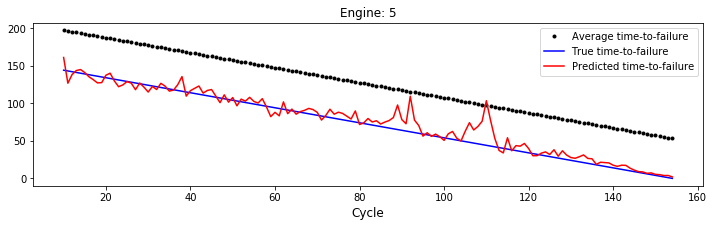

In [9]:
from SAP.utils import plot_RUL
plot_RUL(engine = 5, X = data_training_FD2, engines_to_check = engines_to_check,
         prediction = prediction, real = real, RULtraining = RULtraining, dt = dt)

The above plot shows the remaining useful life prediction (red) along with real time-to-failure (blue) and average time-to-failure (black). Average time-to-failure is calculated using all the engine ids in training data. Plot shows that the model is able to predict well at a given cycle.

#### RUL prediction in Test Data
Next, the model is evaluated against the test data. First, test data is prepared using the remaining useful life provided for every test engine id. Few more information is used to format the test data to input to the model.

In [10]:
from SAP.model import Prepare_TestData

# Prepare test data 
(Xtesting, 
 Ytesting,
 engines,
 all_in_one) = Prepare_TestData(X = data_testing_FD2, 
                               testing_RUL = data_testing_RUL_FD2,
                               settings_min_max_mean = settings_min_max_mean,
                               sensors_min_max_mean = sensors_min_max_mean,
                               time_of_event_max = time_of_event_max,
                               centering = centering,
                               normalization = normalization,
                               dt = dt,
                               all_in_one = False)

[Info] Centering the input test data...
[Info] Normalizing the remaining useful life of test data...
[Info] Assimilating test data for every engine...


In [11]:
# These engines can be tested with trained model for remaining useful life
print engines 

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

Model is evaluated for specified engine ids. Inverse operation (if applicable) of normalization or standardization is also performed at this stage.

In [12]:
# Evaluate model output against given RUL
from SAP.model import Evaluate_Model
(prediction,
 real,
 engines_to_check) = Evaluate_Model(Xtesting, 
                        Ytesting,
                        engines,
                        model, 
                        all_in_one, 
                        engines_to_check = [1,2,3,4,5,6,7,24,121])

# Convert RUL to original scale if normalization is done before
from SAP.model import iNormalization
(prediction,
real) = iNormalization(prediction,
                       real,
                       normalization = normalization,
                       time_of_event_max = time_of_event_max)

[Info] collecting RUL predictions on test data for specified engines...


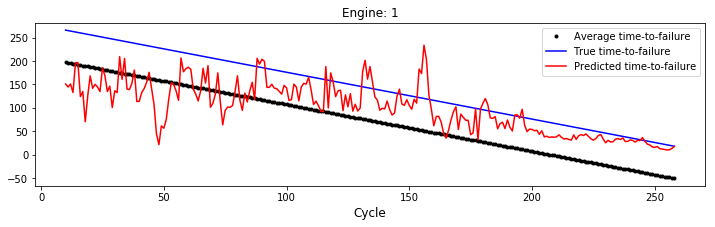

In [13]:
plot_RUL(engine = 1, X = data_testing_FD2, engines_to_check = engines_to_check,
         prediction = prediction, real = real, RULtraining = RULtraining, dt = dt)

The above plot shows the remaining useful life prediction (red), real time-to-failure (blue) and average time-to-failure (black). The predicted curve follows the average time-to-failure in the begining of cycle and then follows the true time-to-failure curve as it approaches the time of event. The erratic nature of the predictions suggests for model improvement or testing different configuration of the model. User of this package can be easily perform this task in the model development section and evaluate the model.